In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=3)

In [2]:
SIZE = 4  # map size

env = gym.make('FrozenLake-v1', is_slippery=False)
print(env.desc)

def int2loc(x):
    """
    Convert state number into 2d matrix index
    e.g. 3 -> (0, 4),  4 -> (1, 0)
    """
    return (x // SIZE, x % SIZE)

assert int2loc(8) == (2,0)

[[b'S' b'F' b'F' b'F']
 [b'F' b'H' b'F' b'H']
 [b'F' b'F' b'F' b'H']
 [b'H' b'F' b'F' b'G']]


# SARSA

In [3]:
class SARSA():
    
    def __init__(self, choice=[0,1,2,3], shape=(SIZE, SIZE, 4), e=0.8, y=0.9, lr=1e-1,):
        
        self.e  = e  # epsilon
        self.y  = y  # gamma
        self.lr = lr  # learning rate
        self.q = np.random.randn(*shape)  # q value array
        self.choice = choice  # action space
        
        self.test_mode = False
    
    def action(self, state):
        
        # exploration
        if not self.test_mode and np.random.rand() <= self.e:
            action = np.random.choice(self.choice)
            
        # greedy policy
        else:
            action = np.argmax(self.q[state])
        return action
    
    def learn(self, state, action, state_, action_, reward, done):
        
        # (pseudocode on p130)
        q_next = self.q[(*state_, action_)] if not done else 0.0
        td_error = reward + self.y*q_next - self.q[(*state, action)]
        self.q[(*state, action)] += self.lr * td_error

In [4]:
def episode(env, agent):
    
    state = int2loc(env.reset())
    action = agent.action(state)
    
    for step in range(MAX_STEPS):
        
        # take action & observe
        state_, reward, done, _ = env.step(action)
        state_ = int2loc(state_)
        
        # choose next action
        action_ = agent.action(state_)
        
        # update q value
        agent.learn(state, action, state_, action_, reward, done);
        
        # iter to next step
        state = state_
        action = action_
        
        if done:
            return step

In [9]:
EPISODES = 10000
MAX_STEPS = 100  # max steps before terminating an episode

agent = SARSA(e=1, lr=0.2)
steps = []

for i in range(EPISODES):
    
    episode(env, agent);
    
    if agent.e >= 0.2:
        agent.e *= 0.996
        
    if i % 20 == 0:
        agent.test_mode = True
        steps.append(episode(env, agent))
        agent.test_mode = False

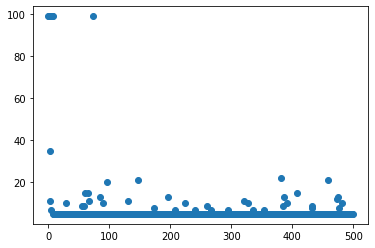

In [10]:
# learning curve
plt.scatter(range(len(steps)), steps);

In [11]:
# visualize policy
arrows = np.array(['←','↓','→','↑'])
np.array([arrows[np.argmax(agent.q, axis=2)[i,j]] 
          if (env.desc[i,j] == env.desc[0,0]) or (env.desc[i,j] == env.desc[0,1]) else env.desc[i,j]
          for i in range(4) for j in range(4)
          ]).reshape(4,4)

array([['↓', '←', '←', '←'],
       ['↓', 'H', '↓', 'H'],
       ['→', '→', '↓', 'H'],
       ['H', '→', '→', 'G']], dtype='<U1')

# Q-Learning

In [12]:
class QL(SARSA):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def learn(self, state, action, state_, action_, reward, done):
        
        # (6.8 on p131)
        q_next = np.max(self.q[state_]) if not done else 0.0         # <- difference
        td_error = reward + self.y*q_next - self.q[(*state, action)]
        self.q[(*state, action)] += self.lr * td_error

In [14]:
EPISODES = 10000
MAX_STEPS = 100

agent = QL(e=1, lr=0.6)
steps = []

for i in range(EPISODES):
    
    episode(env, agent);
    
    if agent.e >= 0.2:
        agent.e *= 0.996
        
    if i % 20 == 0:
        agent.test_mode = True
        steps.append(episode(env, agent))
        agent.test_mode = False

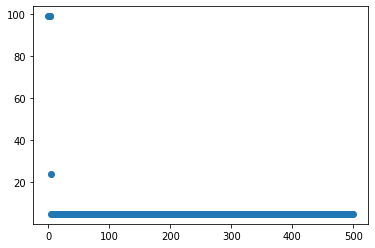

In [15]:
plt.scatter(range(len(steps)), steps);

In [16]:
np.array([arrows[np.argmax(agent.q, axis=2)[i,j]] 
          if (env.desc[i,j] == env.desc[0,0]) or (env.desc[i,j] == env.desc[0,1]) else env.desc[i,j]
          for i in range(4) for j in range(4)
          ]).reshape(4,4)

array([['↓', '←', '←', '←'],
       ['↓', 'H', '↑', 'H'],
       ['→', '↓', '↓', 'H'],
       ['H', '→', '→', 'G']], dtype='<U1')

## Cliff Walking (Example 6.6)

In [17]:
# cliff environment
class Cliff():
    
    def __init__(self):
        self.map = np.ones((4,6)) * (-1)
        self.map[0,5] = 0  # goal
        self.map[0,1:5] = -100  # cliff
        self.actions = [(0,-1),(1,0),(0,1),(-1,0)]
        self.reset()
    
    def reset(self):
        self.loc = (0,0)
        return self.loc
    
    def step(self, action):
        x, y = self.actions[action]
        x = np.clip(self.loc[0] + x, 0, 3)
        y = np.clip(self.loc[1] + y, 0, 5)
        self.loc = (x, y)
        reward = self.map[self.loc]
        return self.loc, reward, reward!=(-1), None  # to be consistent withh gym's return

In [18]:
# payoff map
env = Cliff()
print(env.map)

[[  -1. -100. -100. -100. -100.    0.]
 [  -1.   -1.   -1.   -1.   -1.   -1.]
 [  -1.   -1.   -1.   -1.   -1.   -1.]
 [  -1.   -1.   -1.   -1.   -1.   -1.]]


In [19]:
# episode function without int2loc
def episode2(env, agent):
    
    state = env.reset()
    action = agent.action(state)
    
    for step in range(MAX_STEPS):
        
        # take action & observe
        state_, reward, done, _ = env.step(action)
        
        # choose next action
        action_ = agent.action(state_)
        
        # update q value
        agent.learn(state, action, state_, action_, reward, done);
        
        # iter to next step
        state = state_
        action = action_
        
        if done:
            return step

In [20]:
ql    = QL(e=0.1, shape=(4,6,4))
sarsa = SARSA(e=0.1, shape=(4,6,4))

for _ in range(10000):
    episode2(env, ql)
    episode2(env, sarsa)

In [21]:
# q learning policy
# (optimal, shortest)
np.array([arrows[np.argmax(ql.q, axis=2)[i,j]]
          if env.map[i,j]==-1 else env.map[i,j]
          for i in range(4) for j in range(6)
          ]).reshape(4,6)

array([['↓', '-100.0', '-100.0', '-100.0', '-100.0', '0.0'],
       ['→', '→', '→', '→', '→', '↑'],
       ['↑', '↑', '→', '↑', '→', '↑'],
       ['↓', '↑', '→', '→', '→', '↑']], dtype='<U32')

In [22]:
# sarsa policy
# (safest under epsilon-greedy)
np.array([arrows[np.argmax(sarsa.q, axis=2)[i,j]]
          if env.map[i,j]==-1 else env.map[i,j]
          for i in range(4) for j in range(6)
          ]).reshape(4,6)

array([['↓', '-100.0', '-100.0', '-100.0', '-100.0', '0.0'],
       ['↓', '↓', '↓', '↓', '→', '↑'],
       ['→', '↓', '→', '↓', '→', '↑'],
       ['→', '→', '→', '→', '→', '↑']], dtype='<U32')

# Expected Sarsa

In [23]:
class QL(SARSA):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def learn(self, state, action, state_, action_, reward, done):
        
        # (6.9 on p133)
        pi_next = np.ones(len(self.choice)) * self.e / len(self.choice)
        pi_next[np.argmax(self.q[state_])] = 1 - self.e * (len(self.choice)-1) / len(self.choice)
        q_next = np.sum(pi_next * self.q[state_]) if not done else 0.0
        
        td_error = reward + self.y*q_next - self.q[(*state, action)]
        
        self.q[(*state, action)] += self.lr * td_error
        
    def generate_policy(self):
        self.policy = np.argmax(self.q, axis=2)
        np.ones(self.shape) * self.e / len(self.choice)

# (NOT TESTED YET)

# Double Q-Learning

In [24]:
class DQL():
        
    def __init__(self, choice=[0,1,2,3], shape=(SIZE, SIZE, 4), e=0.8, y=0.9, lr=1e-1,):
        
        self.e  = e
        self.y  = y
        self.lr = lr
        self.choice = choice
        self.q1 = np.random.randn(*shape)
        self.q2 = np.random.randn(*shape)
        
        self.test_mode = False
    
    def action(self, state):
        if not self.test_mode and np.random.rand() <= self.e:
            action = np.random.choice((self.choice))
        else:
            action = np.argmax(self.q1[state] + self.q2[state])
        return action
    
    def learn(self, state, action, state_, action_, reward, done):
        
        # (p136)
        if np.random.rand() <= 0.5:
            q_next = self.q2[(*state_, np.argmax(self.q1[state_]))] if not done else 0.0
            td_error = reward + self.y*q_next - self.q1[(*state, action)]
            self.q1[(*state, action)] += self.lr * td_error
        
        else:
            q_next = self.q1[(*state_, np.argmax(self.q2[state_]))] if not done else 0.0
            td_error = reward + self.y*q_next - self.q2[(*state, action)]
            self.q2[(*state, action)] += self.lr * td_error
            
    def generate_policy(self):
        self.policy = np.argmax(self.q1 + self.q2, axis=2)
        return self.policy

In [25]:
EPISODES = 10000
MAX_STEPS = 100

env = gym.make('FrozenLake-v1', is_slippery=False)
agent = DQL(e=1, lr=1)
steps = []

for i in range(EPISODES):
    
    episode(env, agent);
    
    if agent.e >= 0.2:
        agent.e *= 0.996
        
    if i % 20 == 0:
        agent.test_mode = True
        steps.append(episode(env, agent))
        agent.test_mode = False

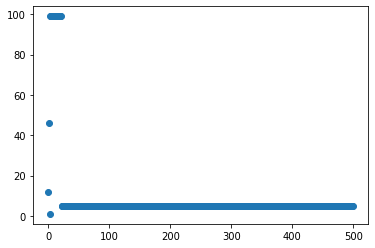

In [27]:
plt.scatter(range(len(steps)), steps);

In [28]:
np.array([arrows[agent.generate_policy()[i,j]] 
          if (env.desc[i,j] == env.desc[0,0]) or (env.desc[i,j] == env.desc[0,1]) else env.desc[i,j]
          for i in range(4) for j in range(4)
          ]).reshape(4,4)

array([['↓', '←', '←', '↓'],
       ['↓', 'H', '↓', 'H'],
       ['→', '↓', '↓', 'H'],
       ['H', '→', '→', 'G']], dtype='<U1')

In [24]:
# TODO: implement maximization bias example (p134)